# Tarea 3

Jairo Saul Diaz Soto

Dr. Jean-Bernanrd Hayet

Vision Computacional I

2024 / 02 / 28

# Ejercicio 1: Implementando funcion de estimacion de la matriz fundamental

## Contruyendo el algoritmo

In [150]:
import cv2
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [151]:
## Funcion para calcular los puntos emparejados entre las imagenes
def match_pts(img1, img2, mf=500, gmp=0.15):
    ## Estableciendo los parametros de los matchs
    MAX_FEATURES = mf
    GOOD_MATCH_PERCENT = gmp

    ## Detectando las caaracteristicas ORB y calculando los descriptores
    orb = cv2.ORB_create(MAX_FEATURES)
    kp1, dsc1 =  orb.detectAndCompute(img1, None)
    kp2, dsc2 =  orb.detectAndCompute(img2, None)

    ## Caracterizando los emparejamientos y obteniendo la lista de coincidencias
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE)
    matches = list(matcher.match(dsc1, dsc2, None))

    ## Ordenando los emparejamientos por su score
    matches.sort(key=lambda x: x.distance, reverse=False)

    ## Quedandonos solo con los mejores emparejamientos
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT )
    matches = matches[:numGoodMatches]
    print("El numero de buenos emparejamientos es: {}".format(numGoodMatches))

    ## Extrayendo los puntos de los emparejamientos
    pts1 = np.zeros((len(matches), 2), dtype=np.float32)
    pts2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        pts1[i,:] = kp1[match.queryIdx].pt
        pts2[i,:] = kp2[match.trainIdx].pt

    ## Regresando los puntos obtenidos
    return pts1, pts2
    

In [152]:
## Contruccion de la matriz para el algoritmo de los 8 puntos
def mat_aux_8pts(pts1, pts2):
    n =  pts1.shape[0]
    A = np.ones((n, 9))
    for i in range(n):
        A[i, 0] = pts1[i, 0] * pts2[i, 0]
        A[i, 1] = pts1[i, 1] * pts2[i, 0]
        A[i, 2] = pts1[i, 0]
        A[i, 3] = pts1[i, 0] * pts2[i, 1]
        A[i, 4] = pts1[i, 1] * pts2[i, 1]
        A[i, 5] = pts1[i, 1]
        A[i, 6] = pts1[i, 0]
        A[i, 7] = pts1[i, 1]
    return A

In [153]:
## Funcion para contar los inliers
def count_inliers(F, points1, points2, threshold):
    # Evalúa la cantidad de inliers basándose en la distancia epipolar
    lines = cv2.computeCorrespondEpilines(points1.reshape(-1, 1, 2), 1, F)
    lines = lines.reshape(-1, 3)
    distances = np.abs(np.sum(lines * np.hstack((points2, np.ones((len(points2), 1)))), axis=1))
    
    # Encuentra los índices de los puntos inliers
    inliers_indices = np.where(distances < threshold)[0]
    
    # Número de inliers
    inliers_count = len(inliers_indices)
    
    return inliers_count, inliers_indices

## Algoritmo de RANSAC para encontrar la matriz con mas inliners
def ransac_8points(A, pts1, pts2, max_iter, th = 0.05):
    best_F = None
    best_inliers = 0
    for i in range(max_iter):
        ## Se esocgen 8 puntos al azar
        r_idx = np.array(np.random.choice(len(pts1), 8, replace = False))
        Amin = A[r_idx, :]

        ## Se realiza la descomposicion 
        U, S, Vt = np.linalg.svd(Amin)

        ## Vamos a evaluar la matriz
        F = Vt[-1, :].reshape(3, 3)
        inliersc, inliers_idx = count_inliers(F, pts1, pts2, th)
        if inliersc > best_inliers:
            best_inliers = inliersc
            best_F = F
            best_idx = inliers_idx
    print("Se encontraron {} inliers.".format(best_inliers))
    return best_F, best_idx
    
    

In [154]:
def drawlines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    nimg1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    nimg2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        cv2.line(nimg1, (x0, y0), (x1, y1), color, 1)
        
        # Convierte las coordenadas a enteros
        pt1 = tuple(map(int, pt1))
        pt2 = tuple(map(int, pt2))
        
        cv2.circle(nimg1, pt1, 5, color, -1)
        cv2.circle(nimg2, pt2, 5, color, -1)
    return nimg1, nimg2

In [155]:
def estim_fundamental_matrix(fimg1, fimg2, NMax, th):
    ## Adecuamos las imagenes para trabajarlas
    img1 = cv2.imread(fimg1, 0)
    img2 = cv2.imread(fimg2, 0)

    ## Se obtienen los puntos emparejados entre las imagenes
    pts1, pts2 = match_pts(img1, img2)

    ## Normalizando los puntos
    u = (img1.shape[1] / 2)
    u_p = (img2.shape[1] / 2)
    v = (img1.shape[0] / 2)
    v_p  = (img2.shape[0] / 2)
    pts1_norm = np.asarray([pts1[:, 0] / u, pts1[:, 1] / v]).T
    pts2_norm = np.asarray([pts2[:, 0] / u_p, pts2[:, 1] / v_p]).T

    ## Se realiza la construccion de la matriz para poder realizar el algoritmo de los 8 puntos
    A_mat = mat_aux_8pts(pts1_norm, pts2_norm)

    ## Se aplica el metodo de RANSAC para obtener la matriz fundamental
    F, mask = ransac_8points(A_mat, pts1_norm, pts2_norm, NMax, th)

    ##De-normalizamos para obtener el verdadero F
    F[0,0] *= (u*u_p)
    F[0,1] *= (v*u_p)
    F[0,2] *= (u_p)
    F[1,0] *= (u*v_p)
    F[1,1] *= (v*v_p)
    F[1,2] *= (v_p)
    F[2,0] *= (u)
    F[2,1] *= (v)

    ## Se proyecta sobre el espacio de las matrices de rango 2
    U, S, Vt = np.linalg.svd(F)
    lmin = np.argmin(S)
    S[lmin] = 0.0
    F_hat = U @ np.diag(S) @ Vt

    lines = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines = lines.reshape(-1, 3)

    # Dibujar líneas en la segunda imagen (img2)
    img1_lines, img2_lines = drawlines(img1, img2, lines, pts1[mask], pts2[mask])

    # Mostrar las imágenes con las líneas dibujadas
    plt.subplot(121), plt.imshow(img1_lines)
    plt.subplot(122), plt.imshow(img2_lines)
    plt.show()

    return F_hat

## Probando el algoritmo

In [156]:
images = glob.glob('*.JPG')

El numero de buenos emparejamientos es: 75
Se encontraron 67 inliers.


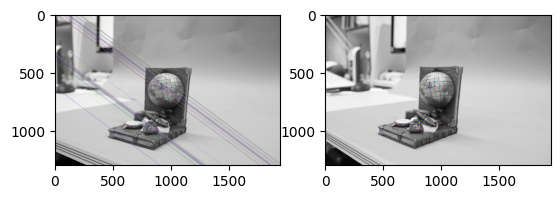

El numero de buenos emparejamientos es: 75
Se encontraron 54 inliers.


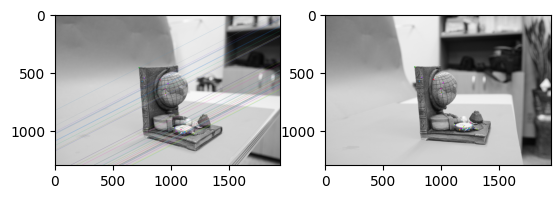

El numero de buenos emparejamientos es: 75
Se encontraron 67 inliers.


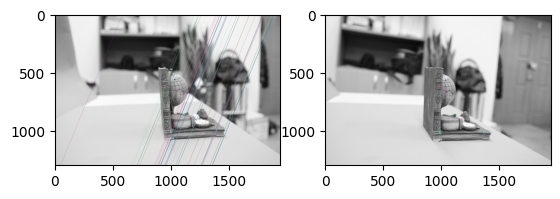

El numero de buenos emparejamientos es: 75
Se encontraron 67 inliers.


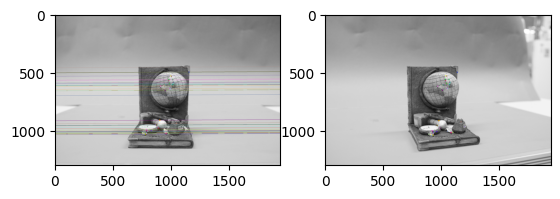

El numero de buenos emparejamientos es: 75
Se encontraron 28 inliers.


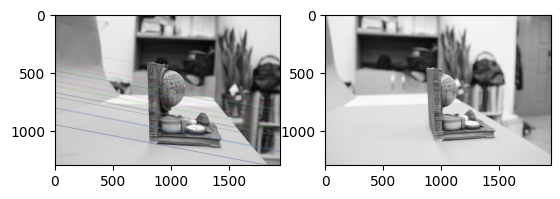

El numero de buenos emparejamientos es: 75
Se encontraron 54 inliers.


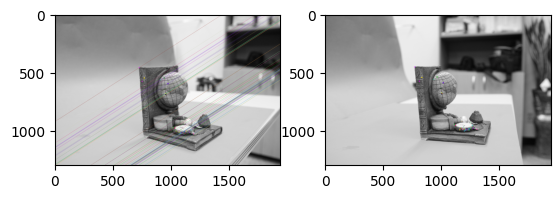

El numero de buenos emparejamientos es: 75
Se encontraron 54 inliers.


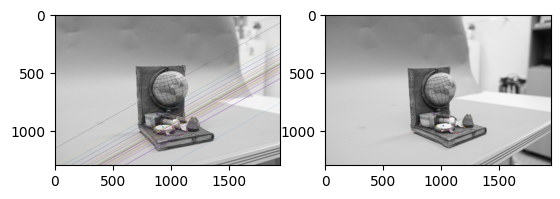

El numero de buenos emparejamientos es: 75
Se encontraron 67 inliers.


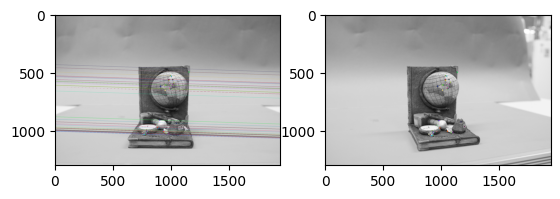

El numero de buenos emparejamientos es: 75
Se encontraron 34 inliers.


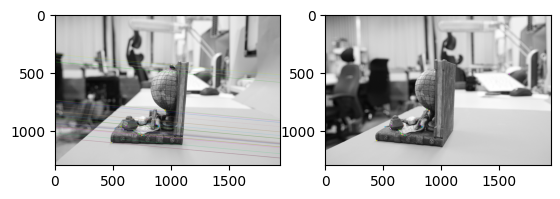

El numero de buenos emparejamientos es: 75
Se encontraron 67 inliers.


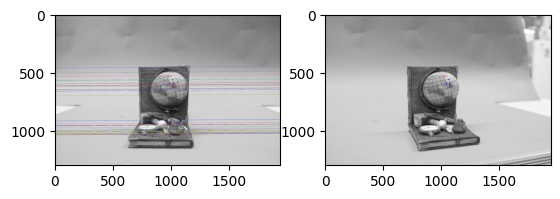

El numero de buenos emparejamientos es: 75
Se encontraron 48 inliers.


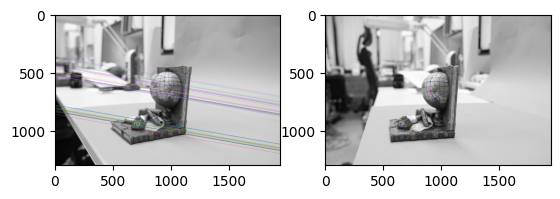

El numero de buenos emparejamientos es: 75
Se encontraron 18 inliers.


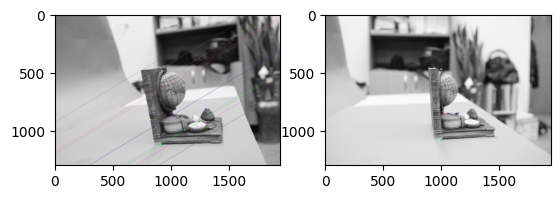

El numero de buenos emparejamientos es: 75
Se encontraron 54 inliers.


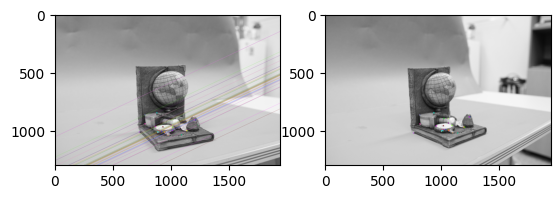

El numero de buenos emparejamientos es: 75
Se encontraron 49 inliers.


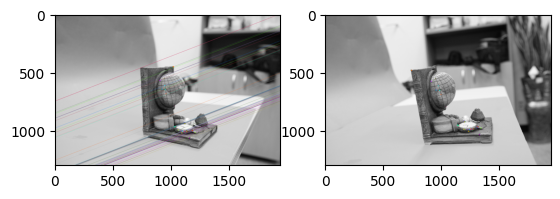

El numero de buenos emparejamientos es: 75
Se encontraron 44 inliers.


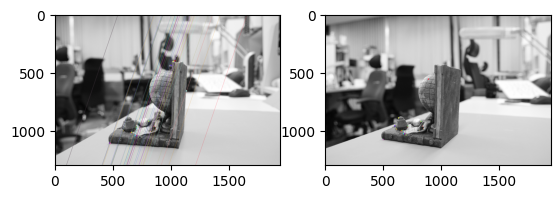

In [157]:
for i in range(15):
    r_idx = np.random.choice(len(images)-2, 2, replace = False)
    estim_fundamental_matrix(images[r_idx[0]], images[r_idx[0]+2], 500, .03)

# Ejercicio 2: Puntos 3D

## Estimando la matriz escencial

In [158]:
## Obteniendo dos puntos aleatorios
r_idx = np.random.choice(len(images), 2, replace = False)

## Tomamos asi dos imagenes al azar y se obtiene la matriz funamental
img1 = cv2.imread(images[r_idx[0]], 0)
img2 = cv2.imread(images[r_idx[1]], 0)

## Obteniendo los puntos 
orb = cv2.ORB_create(500)

kp1, dsc1 = orb.detectAndCompute(img1, None)
kp2, dsc2 = orb.detectAndCompute(img2, None)

## Obteniendo las correspondencias
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = list(matcher.match(dsc1, dsc2, None))

##Ordenando
matches.sort(key=lambda x: x.distance, reverse= False)
k = int(len(matches) * 0.15)
matches = matches[:k]
print("Mejores puntos encontrados: ",k)

Mejores puntos encontrados:  75


In [159]:
# Extrayendo los mejores puntos
pts1 = np.zeros((len(matches), 2), dtype=np.float32)
pts2 = np.zeros((len(matches), 2), dtype=np.float32)
for i, match in enumerate(matches):
    pts1[i, :] = kp1[match.queryIdx].pt
    pts2[i, :] = kp2[match.trainIdx].pt

In [160]:
# Calculando la matriz fundamental
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
print(F)

[[-4.84917215e-06  5.10879885e-07  2.42138826e-03]
 [ 5.48003955e-06 -3.26326061e-07 -2.98436624e-03]
 [-1.47866721e-03 -1.09084617e-04  1.00000000e+00]]


In [161]:
## Calculando la matriz escencial
K = np.loadtxt("K.txt")
E = K.T @ F @ K
print(E)

[[-13.99554505   1.47449237  -3.32957478]
 [ 15.81639191  -0.9418397    3.6177364 ]
 [ -4.48699731   0.29897814  -1.03268842]]


## Obteniendo el desplazamiento entre las camaras

In [162]:
def decompose_essential_matrix(E):
    U, _, Vt = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    
    # Cuatro posibles combinaciones de rotación y traslación
    R1 = U @ W @ Vt
    R2 = U @ W.T @ Vt
    t1 = U[:, 2]
    t2 = -U[:, 2]

    return R1, R2, t1, t2

In [163]:
R1, R2, t1, t2 = decompose_essential_matrix(E)
print(R1)
print(R2)
print(t1)
print(t2)

[[-0.82246085 -0.56864235 -0.01428384]
 [-0.48899633  0.71964642 -0.4929418 ]
 [ 0.2905869  -0.39844059 -0.86994503]]
[[ 0.8024324   0.58713357  0.10666027]
 [ 0.58587431 -0.80908879  0.04611532]
 [ 0.11337348  0.02548508 -0.99322554]]
[-0.04815721  0.23293732  0.97129866]
[ 0.04815721 -0.23293732 -0.97129866]


## Triangulando los puntos

In [164]:
# Función para realizar la triangulación
def triangulate_points(P1, P2, pts1, pts2):
    # Triangulación de puntos
    points_3d_homogeneous = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)

    # Normalización de coordenadas homogéneas
    points_3d_homogeneous /= points_3d_homogeneous[3, :]

    # Coordenadas 3D
    points_3d = points_3d_homogeneous[:3, :].T

    return points_3d

In [165]:
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
R1, R2, t1, t2 = decompose_essential_matrix(E)
t1 = np.reshape(t1, (-1, 1))
t2 = np.reshape(t2, (-1, 1))
P21 = K @ np.hstack((R1, t1))
P22 = K @ np.hstack((R1, t2))
P23 = K @ np.hstack((R2, t1))
P24 = K @ np.hstack((R2, t2))

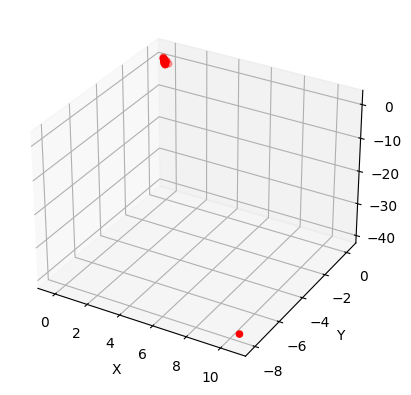

In [166]:
# Triangulación
points_3d = triangulate_points(P1, P21, pts1, pts2)

# Visualización 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

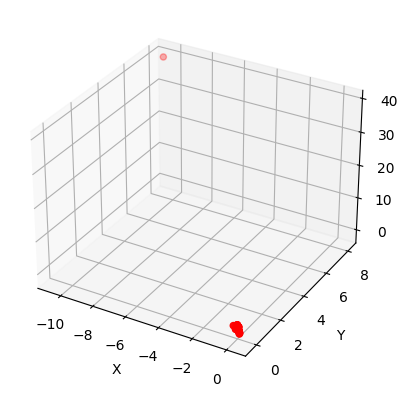

In [167]:
# Triangulación
points_3d = triangulate_points(P1, P22, pts1, pts2)

# Visualización 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

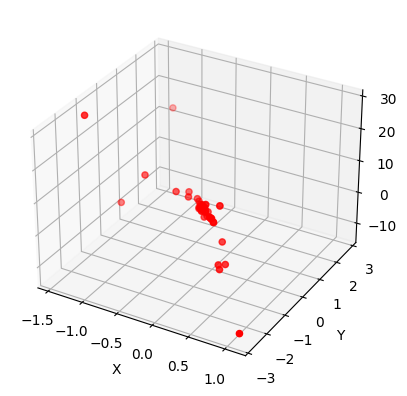

In [168]:
# Triangulación
points_3d = triangulate_points(P1, P23, pts1, pts2)

# Visualización 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

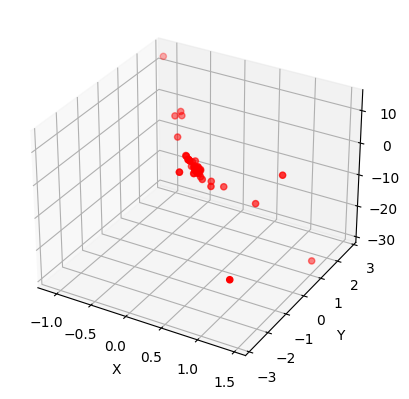

In [169]:
# Triangulación
points_3d = triangulate_points(P1, P24, pts1, pts2)

# Visualización 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='r', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Ejercicio 3: Verificando la proyeccion 3D

Bien para mostrar que se cumple la siguiente ecuacion
$$
    p' \propto K'RK^{-1}p + \frac{1}{Z}K't
$$
Podemos partir de la transofrmacion que aplica cada camara, de forma general la primer camara se puede establecer como
$$
    P = K[I | 0]
$$
y para la segunda camara
$$
    P' = K[R | t]
$$
Entonces, la proyeccion de un punto 3D por la camara principal es tal que
$$
    p = Px
$$
Y para la segunda camara es
$$
    p' = P'x
$$
Si $x$ es el mismo punto proyectado por la misma camara, entonces, lo que se tiene es que este punto se puede obtener de la primer camara como
$$
    x = P^{-1}p
$$
Pero en este caso particular resulta que dada la construccion de la proyeccion se puede escribir como
$$
    x = K^{-1}[I|0]^{-1}p = K^{-1}[I|0]p
$$
Entonces al aplicar la proyeccion sobre la segunda camara se tiene que
$$
    p' = P'x = P'K^{-1}[I|0]p
$$
$$
    p' = K'[R|t]K^{-1}[I|0]p
$$
Que se puede reescribir simplemente como
$$
    p' \propto K'RK^{-1}p + K't
$$

Dado que esto es hasta un factor de proporcionalidad entonces se puede hacer que

$$
    p' = K'RK^{-1}p + \frac{1}{Z}K't
$$

Ahora bien, el primer termino puede ser interpretado como la transformacion del punto 3D entre las camaras, pues aparecen los parametros intrinsecos de ambas, ademas de la rotacion de una camara con respecto a la otra realizando la transformacion del sistema de coordenadas entre las camaras.

El termino Z, como se menciona en la comprobacion de la ecuacion tiene que ver con la proporcionalidad de la transformacion, tambien conocido como la profundidad, la cual refiere a la distancia entre el punto 3D y la distancia de este al plano de proyeccion de la primer camara.


Suponiendo que se tienen puntos en el infinito, implica que el valor de la profundidad es infinito, de esta manera si conoces las proyecciones de dos camaras se puede estimar la rotacion entre ellas tal que
$$
    RK^{-1}p = K'^{-1}p'
$$

Ahora, por otro lado, si ya se ha obtenido el valor de R, se puede estimar la traslacion tal que
$$
    p' = K'RK^{-1}p + \frac{1}{Z}K't
$$
$$
    p' - K'RK^{-1}p = \frac{1}{Z}K't
$$
$$
    t = ZK'^{-1} \left( p' - K'RK^{-1}p \right)
$$